# Python code to reproduce the plots of the paper entiltled "On the profitability of selfish blockchain mining under consideration of ruin "

In [1]:
%config InlineBackend.figure_format = 'retina'
%run -i ./revenue_protocol.py
%run -i ./revenue_selfish.py

# Importation of the time series
π_BTC_data = pd.read_csv("BTC_USD_2013-10-01_2020-05-23-CoinDesk.csv")
tW_data = pd.read_csv("elec_consumption_BTC_CBECI.csv")

# Date reformating
π_BTC_data['Date2'] = pd.to_datetime(π_BTC_data['Date'])
tW_data['Date'] = pd.to_datetime(tW_data['Date and Time'])
π_BTC_df = π_BTC_data[['Date2','Closing Price (USD)']].rename(columns={"Date2": "Date", "Closing Price (USD)": "π_BTC"})
tW_df = tW_data[['Date','GUESS']].rename(columns={"GUESS": "tW"})
# Date considered
Date = '2020-01-01'
# Operational cost of the network
W =  tW_df.tW[tW_df.Date == Date].values[0] * 10**9 / 365.25 / 24
print('On January 1, 2020')
print('The network consumes ' + str(tW_df.tW[tW_df.Date == Date].values[0]) + ' tW per year')  
print('The network consumes ' + str(W) + ' kW per hour')  
# Block reward
n_BTC, π_BTC = 12.5, π_BTC_df.π_BTC[π_BTC_df.Date == '2020-01-01'].values[0]
b = n_BTC * π_BTC
print('The BTC price is $' + str(π_BTC) )
print('The reward for finding a block amount to $' + str(b) )

# Intensity of the Poisson process
λ = 6
print('The time unit is the hour so λ = ' + str(λ))

# Plot parameters
fontsize_axes = 18.0
fontsize_ticker = 16.0
rg = Generator(PCG64(123))


On January 1, 2020
The network consumes 72.1671 tW per year
The network consumes 8232614.647501711 kW per hour
The BTC price is $7174.7440119511
The reward for finding a block amount to $89684.30014938876
The time unit is the hour so λ = 6


## Section 4.1

In [2]:
print('The net profit condition holds if the price is smaller than '
      + str(np.around(λ * b / W, decimals = 3))+
      ' when following the protocol')

The net profit condition holds if the price is smaller than 0.065 when following the protocol


In [4]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 6, 0.06, 0.1
# operational cost per hour
c = p * π_W * W
u_vec = np.arange(1000, 510000, 1000) # Sequence of initial reserves
# u_vec = np.arange(200000, 300000, 10000)
K = 10000 #Number of trajectories
sim_data_t = sim_data_protocol_t(λ, p, t, K, rg)
sim_data_T = sim_data_protocol_T(λ, p, t, K, rg)
res_t = np.array([ψ_V_t_MC(u, t, b, c, p, λ, sim_data_t) for u in u_vec])
res_T = np.array([ψ_V_T_MC(u, t, b, c, p, λ, sim_data_T) for u in u_vec])
ψ_V_MC_df = pd.DataFrame({'u':u_vec,
                    'ψ_u_t':res_t[:,0],
                    'ψ_u_t_low':res_t[:,0] - res_t[:,1],
                    'ψ_u_t_up':res_t[:,0] + res_t[:,1],
                    'V_u_t':res_t[:,2] -u_vec,
                    'V_u_t_low':res_t[:,2] - res_t[:,3],
                    'V_u_t_up':res_t[:,2] + res_t[:,3],
                    'ψ_u_T':res_T[:,0],
                    'ψ_u_T_low':res_T[:,0] - res_T[:,1],
                    'ψ_u_T_up':res_T[:,0] + res_T[:,1],
                    'V_u_T':res_T[:,2] ,
                    'V_u_T_low':res_T[:,2] - res_T[:,3],
                    'V_u_T_up':res_T[:,2] + res_T[:,3]}
                    )

./revenue_selfish.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  p_U = [(1+p*(1-p)+p*(1-p)**2*(1-q))/denom, (p*q*(1-p)**2)/denom, (p**2+p**2*(1-p))/denom]
./revenue_selfish.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if ξ[k] == 1:


The following code generate Figure 2a)

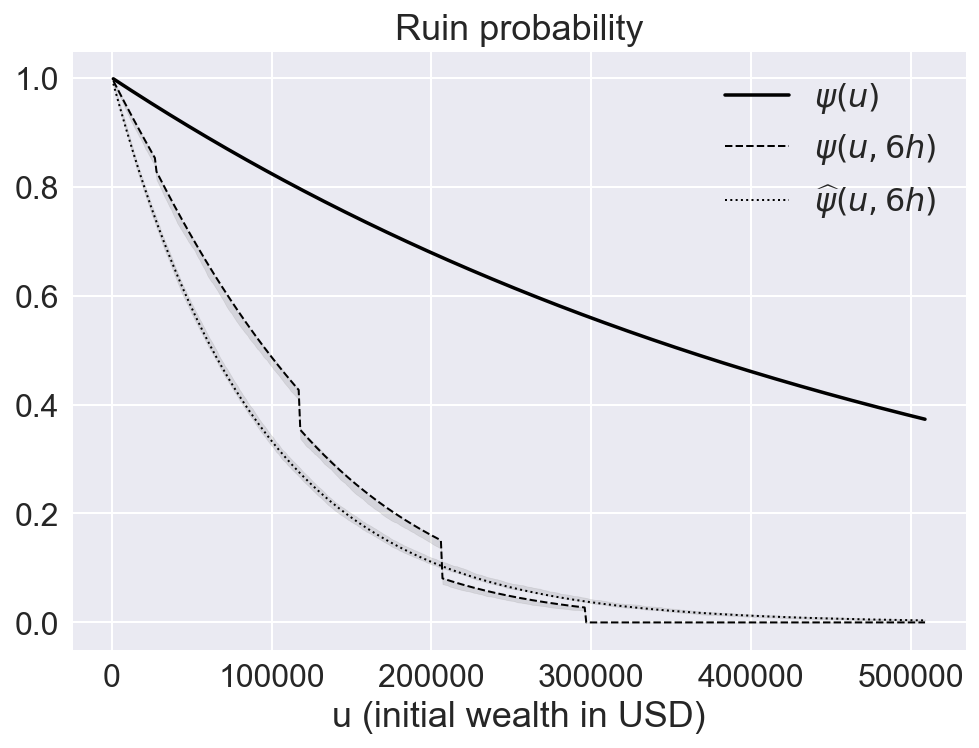

In [5]:
ψ_u_t_vec = [ψ_t(u, t, b, c, p, λ) for u in u_vec]
ψ_u_T_vec = [ψ_T(u, t, b, c, p, λ) for u in u_vec]
ψ_u_vec = [ψ(u, b, c, p, λ) for u in u_vec]

plt.plot(u_vec, ψ_u_vec, '-', label = '$\psi(u)$', color = 'k')
plt.plot(u_vec, ψ_u_t_vec, '--', label = '$\psi(u,6h)$', color = 'k', linewidth=1)
plt.plot(u_vec, ψ_u_T_vec, linestyle = 'dotted', label = '$\widehat{\psi}(u,6h)$', color = 'k', linewidth=1)
plt.fill_between(u_vec, ψ_V_MC_df['ψ_u_t_low'].values, ψ_V_MC_df['ψ_u_t_up'].values, alpha=0.2, color = 'grey')
plt.fill_between(u_vec, ψ_V_MC_df['ψ_u_T_low'].values, ψ_V_MC_df['ψ_u_T_up'].values, alpha=0.2, color = 'grey')
plt.xlabel('u (initial wealth in USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)
plt.savefig("../Figures/pro_rp_MC.pdf", bbox_inches='tight')

Figure 2b)

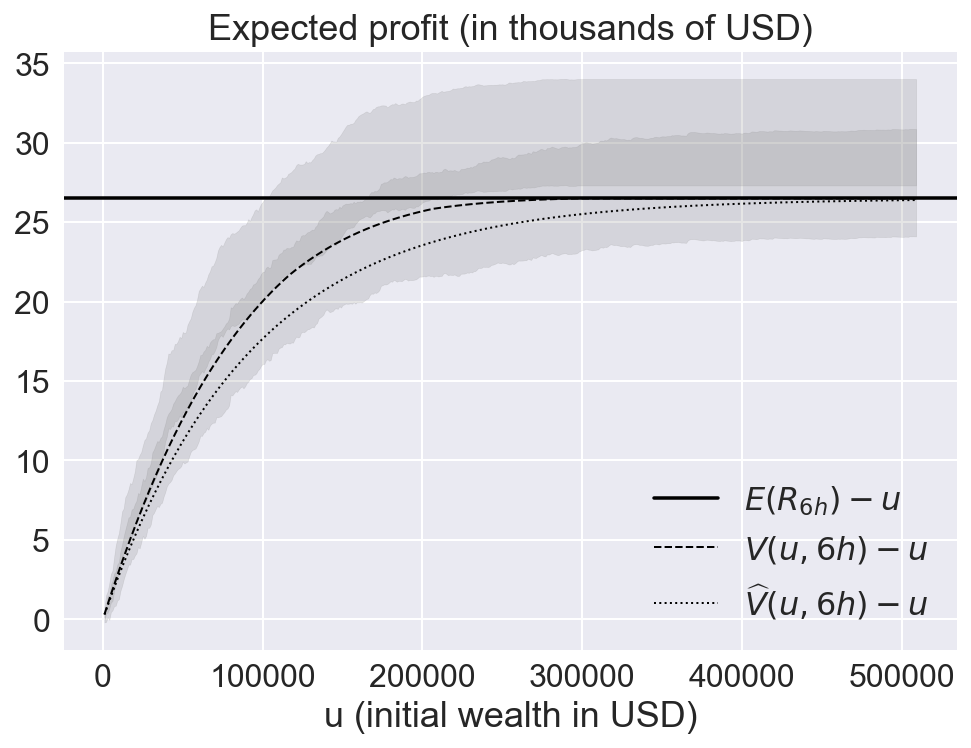

In [6]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 6, 0.06, 0.1
c = p * π_W * W
u_vec = np.arange(1000, 510000, 1000) # Sequence of initial reserves
V_u_t_vec = np.array([V_t(u, t, b, c, p, λ, 40)-u for u in u_vec])/1000
V_u_T_vec = np.array([ V_T(u, t, b, c, p, λ)-u for u in u_vec])/1000
plt.axhline(y = (- c * t + p * λ * b * t)/1000, color = 'k', label = '$E(R_{6h})-u$')
plt.plot(u_vec, V_u_t_vec, '-', label = '$V(u,6h)-u$', linestyle = 'dashed', color = 'k', linewidth=1)
plt.plot(u_vec, V_u_T_vec, linestyle = 'dotted', label = '$\widehat{V}(u,6h)-u$', color = 'k', linewidth=1)
plt.fill_between(u_vec, (ψ_V_MC_df['V_u_t_low'].values -u_vec)/1000, 
                 (ψ_V_MC_df['V_u_t_up'].values -u_vec)/1000, alpha=0.2, color = 'grey')
plt.fill_between(u_vec,  (ψ_V_MC_df['V_u_T_low'].values - u_vec)/1000,
                 (ψ_V_MC_df['V_u_T_up'].values -u_vec)/1000, alpha=0.2, color = 'grey')
plt.xlabel('u (initial wealth in USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in thousands of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)
plt.savefig("../Figures/pro_rev_MC.pdf", bbox_inches='tight')

The following code generates the data for the sensitivity analysis of the ruin probability and expected profit of a miner following the protocol

In [7]:
u_vec = np.arange(10000, 2050000, 50000)
t_vec = np.array([24, 7*24, 14*24])
π_W_vec = np.arange(0.04, 0.1002, 0.002)
p_vec = np.arange(0.01, 0.21, 0.01)
ψ_V_df = pd.DataFrame({'u':[],'t':[],'π_W':[], 'p':[], 'ψ_u_t':[], 'ψ_u':[],'V_u_T':[], 'EG':[]})
for t in t_vec:
    for π_W in π_W_vec:
        for p in p_vec:
            c = p * π_W * W
            res = pd.DataFrame({'u':u_vec,
                        't':np.repeat(t, len(u_vec)), 
                        'π_W':np.repeat(π_W, len(u_vec)),
                        'p':np.repeat(p, len(u_vec)),
                        'ψ_u_t':[ψ_t(u, t, b, c, p, λ) for u in u_vec], 
                        'ψ_u_T':[ψ_T(u, t, b, c, p, λ) for u in u_vec],
                        'ψ_u':[ψ(u, b, c, p, λ) for u in u_vec], 
                        'V_u_T':[ V_T(u, t, b, c, p, λ) for u in u_vec],
                       'EG': np.repeat(- c * t + p * λ * b * t, len(u_vec))})
            ψ_V_df = pd.concat([ψ_V_df, res])
ψ_V_df

,u,t,π_W,p,ψ_u_t,ψ_u,V_u_T,EG,ψ_u_T
0,10000.0,24.0,0.04,0.01,0.833433,0.886736,22835.961907,5.011229e+04,0.743856
1,60000.0,24.0,0.04,0.01,0.335138,0.486145,101622.880800,5.011229e+04,0.169408
2,110000.0,24.0,0.04,0.01,0.000000,0.266525,158178.890529,5.011229e+04,0.038581
3,160000.0,24.0,0.04,0.01,0.000000,0.146120,209671.973680,5.011229e+04,0.008787
4,210000.0,24.0,0.04,0.01,0.000000,0.080109,260012.012421,5.011229e+04,0.002001
...,...,...,...,...,...,...,...,...,...
36,1810000.0,336.0,0.10,0.20,1.000000,1.000000,90052.459714,-1.916246e+07,0.910244
37,1860000.0,336.0,0.10,0.20,1.000000,1.000000,94797.988138,-1.916246e+07,0.907882
38,1910000.0,336.0,0.10,0.20,1.000000,1.000000,99660.928954,-1.916246e+07,0.905527
39,1960000.0,336.0,0.10,0.20,1.000000,1.000000,104640.977538,-1.916246e+07,0.903177


Figure 3a

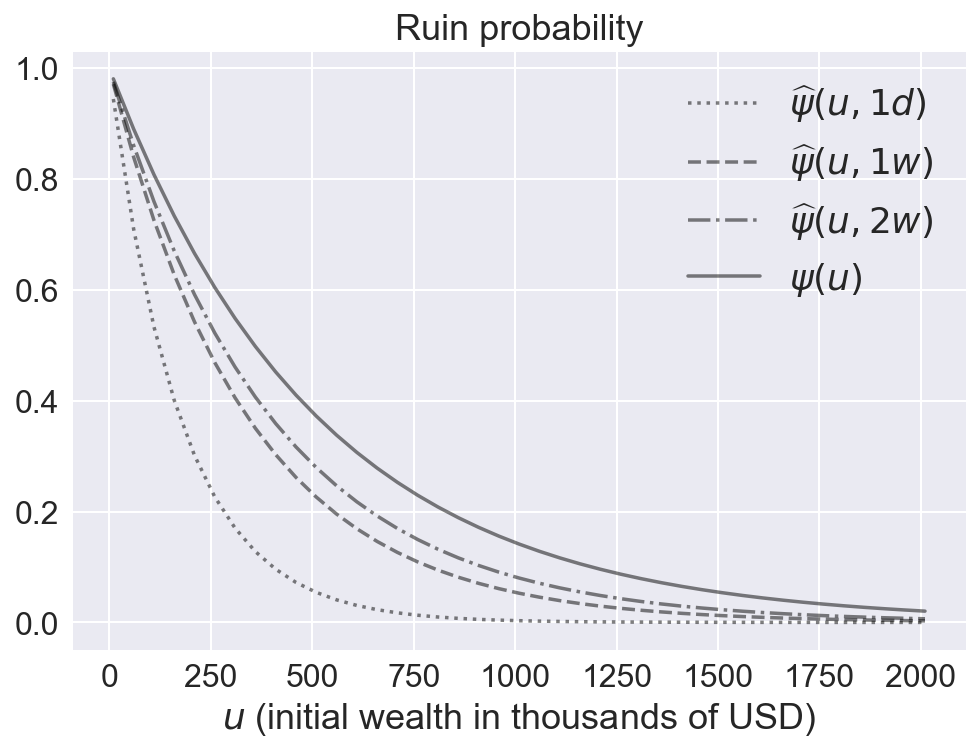

In [8]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
π_W = 0.06
p = 0.1
selector = (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
t_vec_ex = np.array([24, 24*7, 24*14]) 
time_horizon = np.array(['1d', '1w', '2w'])
for k in range(len(t_vec_ex)):
    c = p * π_W * W
#     plt.plot(u_vec, ψ_V_df.ψ_u[(selector) & (ψ_V_df.t == t_vec_ex[k])].values, color = 'k', alpha = 0.2)
    plt.plot(u_vec/1000, ψ_V_df.ψ_u_T[(selector) & (ψ_V_df.t == t_vec_ex[k])].values, color = 'k', alpha = 0.5,
             linestyle = linestyles[k], label = '$\widehat{ψ}(u,'+time_horizon[k] +')$')
plt.plot(u_vec/1000, ψ_V_df.ψ_u[(selector) & (ψ_V_df.t == t_vec_ex[0])].values, color = 'k', alpha = 0.5,
        linestyle = 'solid', label = '$\psi(u)$')
plt.xlabel('$u$ (initial wealth in thousands of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = fontsize_axes)
plt.savefig("../Figures/pro_rp_u.pdf", bbox_inches='tight')

Figure 3b)

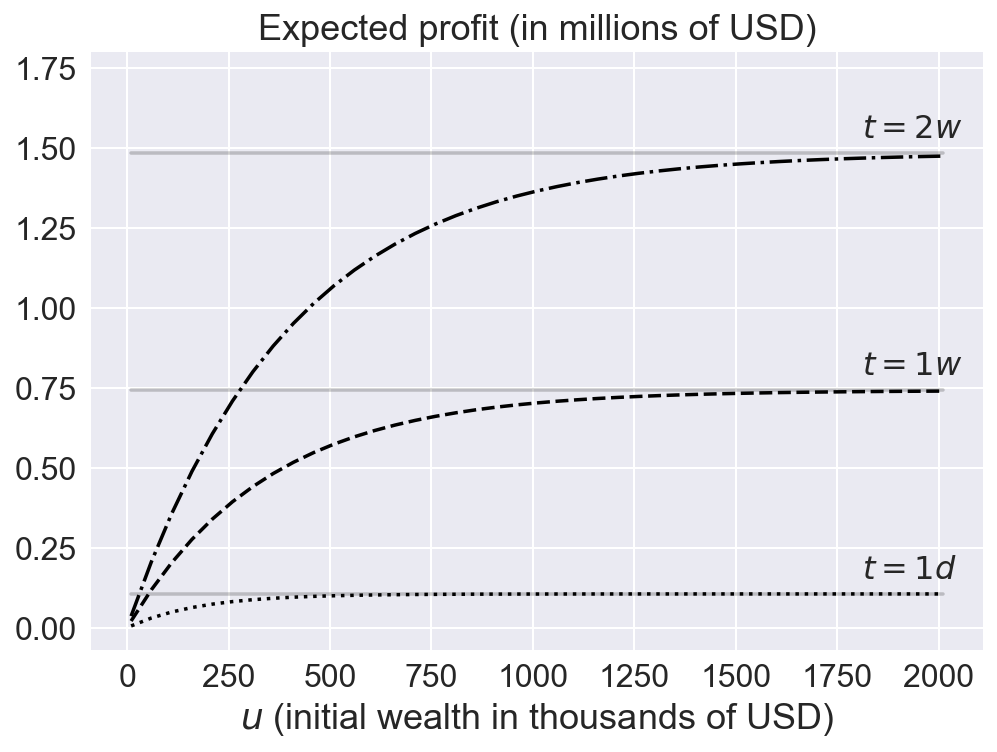

In [9]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
π_W = 0.06
p = 0.1
selector = (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
t_vec_ex = np.array([24, 24*7, 24*14]) 
time_horizon = np.array(['1d', '1w', '2w'])
for k in range(len(t_vec_ex)):
    c = p * π_W * W
    plt.plot(u_vec/1000, (ψ_V_df.EG[(selector) & (ψ_V_df.t == t_vec_ex[k])].values)/1000000, color = 'k', alpha = 0.2)
    plt.plot(u_vec/1000, (ψ_V_df.V_u_T[(selector) & (ψ_V_df.t == t_vec_ex[k])].values -u_vec)/1000000, color = 'k', alpha = 1, 
             linestyle = linestyles[k])
    plt.text(u_vec[-5]/1000, (- c * t_vec_ex[k] + p * λ * b * t_vec_ex[k]+50000)/1000000, '$t = '+time_horizon[k]+'$', fontsize = fontsize_ticker)
plt.xlabel('$u$ (initial wealth in thousands of USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.ylim(top = 1.8)
plt.savefig("../Figures/pro_rev_u.pdf", bbox_inches='tight')

Figure 4a) 

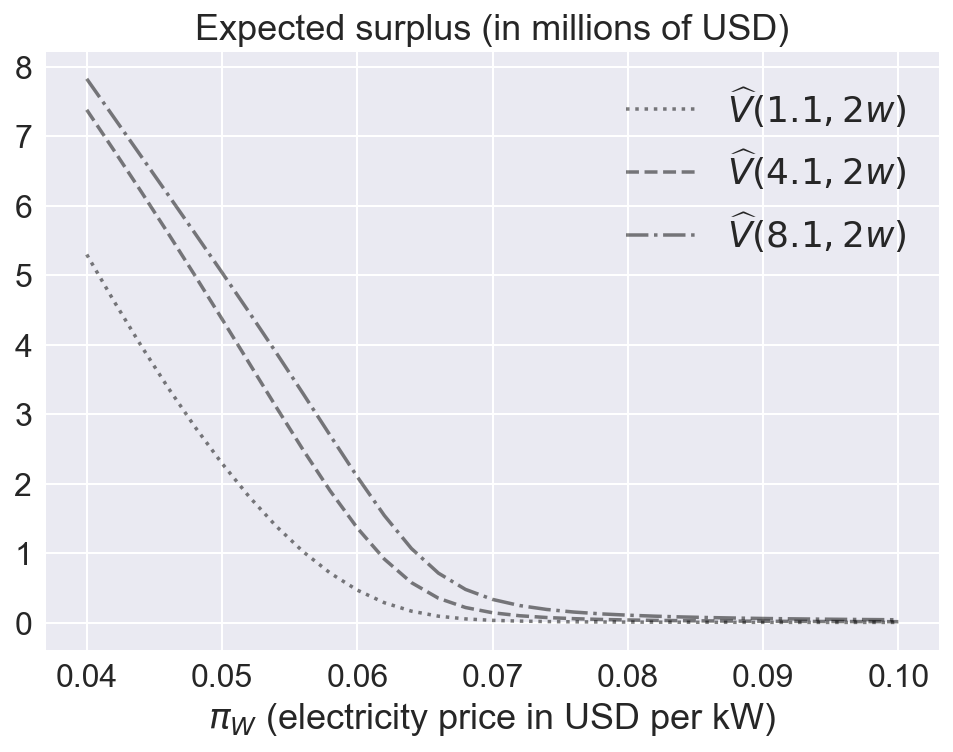

In [10]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
t = 24*14
p = 0.1
selector = (np.around(ψ_V_df.t.values, decimals = 0) == t) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
u_vec_ex = np.array([110000, 410000, 810000]) 
u_vec_names = np.array(['1.1', '4.1', '8.1'])

for k in range(len(u_vec_ex)):
    plt.plot(π_W_vec, ψ_V_df.V_u_T[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values/1000000,
             color = 'k', alpha = 0.5,linestyle = linestyles[k], label = '$\widehat{V}('+u_vec_names[k]+', 2w)$')
plt.xlabel('$\pi_W$ (electricity price in USD per kW)', fontsize = fontsize_axes)
plt.title('Expected surplus (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = fontsize_axes)

plt.savefig("../Figures/pro_rev_pkW.pdf", bbox_inches='tight')

Figure 4b)

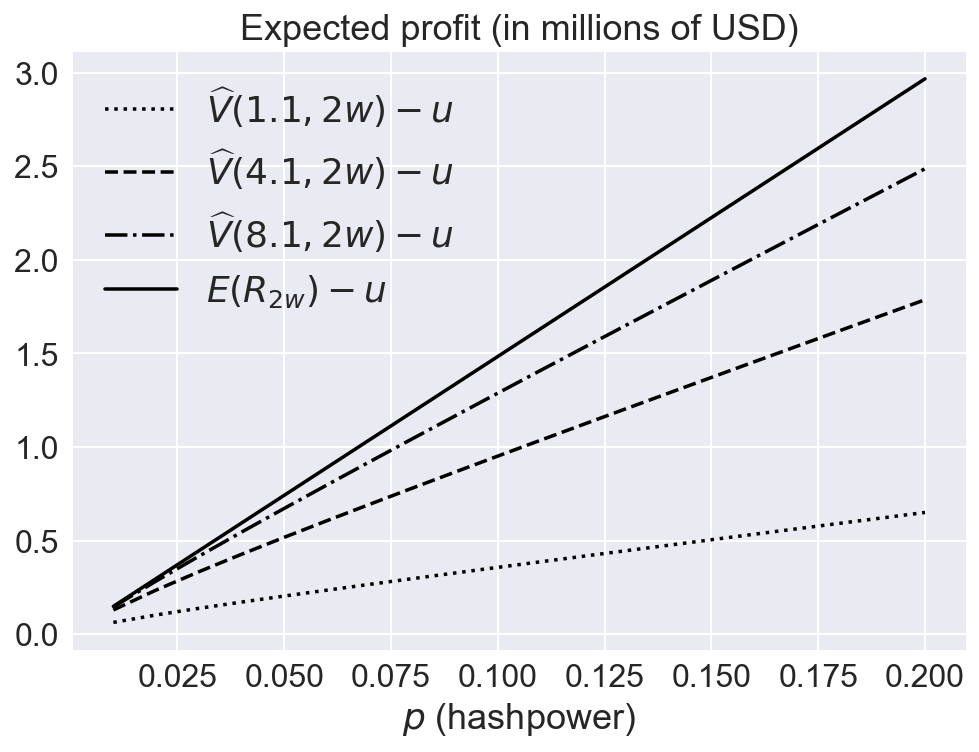

In [11]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
t = 24*14
π_W = 0.06
selector = (np.around(ψ_V_df.t.values, decimals = 0) == t) & (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W)
u_vec_ex = np.array([110000, 410000, 810000]) 
u_vec_names = np.array(['1.1', '4.1', '8.1'])

for k in range(len(u_vec_ex)):
    plt.plot(p_vec, (ψ_V_df.V_u_T[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values - u_vec_ex[k])/1000000,
             color = 'k', alpha = 1,linestyle = linestyles[k], label = '$\widehat{V}('+u_vec_names[k]+',2w)-u$')

plt.plot(p_vec, (ψ_V_df.EG[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values)/1000000,
             color = 'k', alpha = 1,linestyle = 'solid', label = '$E(R_{2w})-u$')
plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = fontsize_axes)

plt.savefig("../Figures/pro_rev_p.pdf", bbox_inches='tight')

The following code generates the data for the illustration of the opportunity for the miner to join a mining pool

In [12]:
n_miner_vec = np.arange(1,101,1)
t_vec = np.array([24, 7*24, 14*24])
u = 10000
p_miner= 0.01
π_W = 0.06
ψ_V_pool = pd.DataFrame({'n_miner':[],'t':[], 'ψ_u_t':[], 'V_u_T':[]})
for t in t_vec:
    res = pd.DataFrame({'n_miner':n_miner_vec,
                        't':np.repeat(t, len(n_miner_vec)),
                        'ψ_u_t':np.array([ψ_t(n_miner *u, t, b, n_miner * p_miner * π_W * W,  n_miner * p_miner, λ) 
                                          for n_miner in n_miner_vec]),
                        'ψ_u_T':np.array([ψ_t(n_miner *u, t, b, n_miner * p_miner * π_W * W,  n_miner * p_miner, λ) 
                                          for n_miner in n_miner_vec]),
                        'V_u_T':np.array([V_T(n_miner *u, t, b, n_miner * p_miner * π_W * W,  n_miner * p_miner, λ) / n_miner 
                                          for n_miner in n_miner_vec])
                       })
    ψ_V_pool = pd.concat([ψ_V_pool, res])

Figure 5a

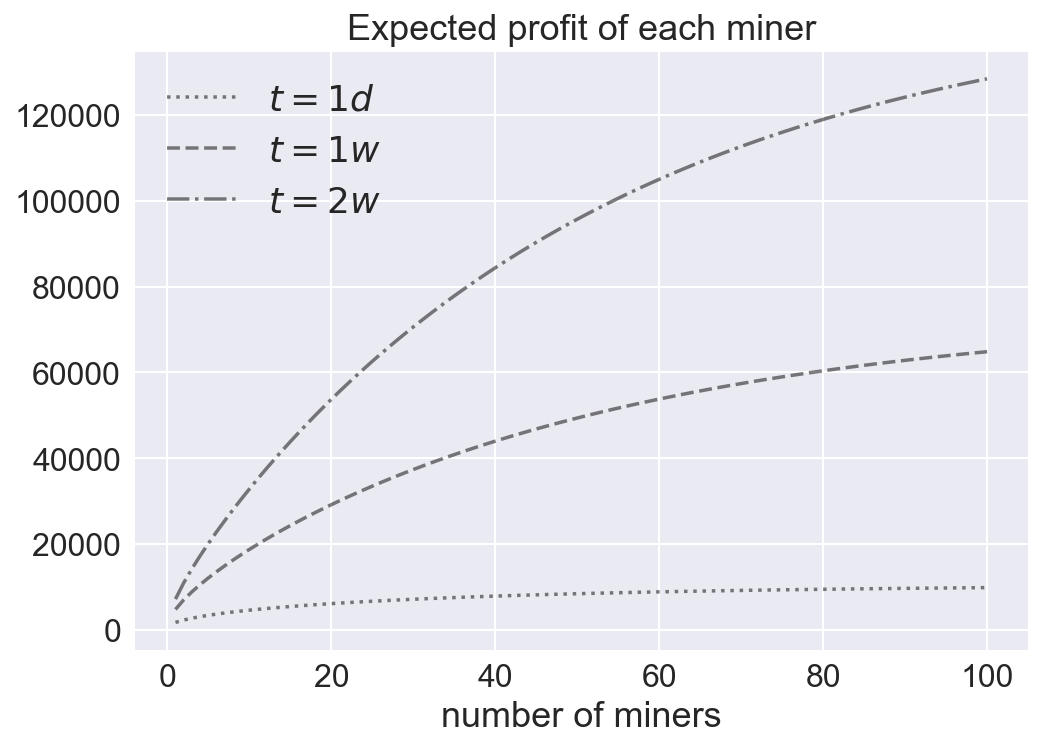

In [13]:
linestyles = ['dotted', 'dashed', 'dashdot']
t_names = np.array(['1d', '1w', '2w'])

for k in range(len(t_vec)):
    plt.plot(n_miner_vec, (ψ_V_pool.V_u_T[np.around(ψ_V_pool.t.values, decimals = 0) == t_vec[k]].values - u),
             color = 'k', alpha = 0.5,linestyle = linestyles[k], label = '$t='+t_names[k]+'$')

plt.xlabel('number of miners', fontsize = fontsize_axes)
plt.title('Expected profit of each miner', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = fontsize_axes)

plt.savefig("../Figures/pro_rev_pool.pdf", bbox_inches='tight')

Figure 5b

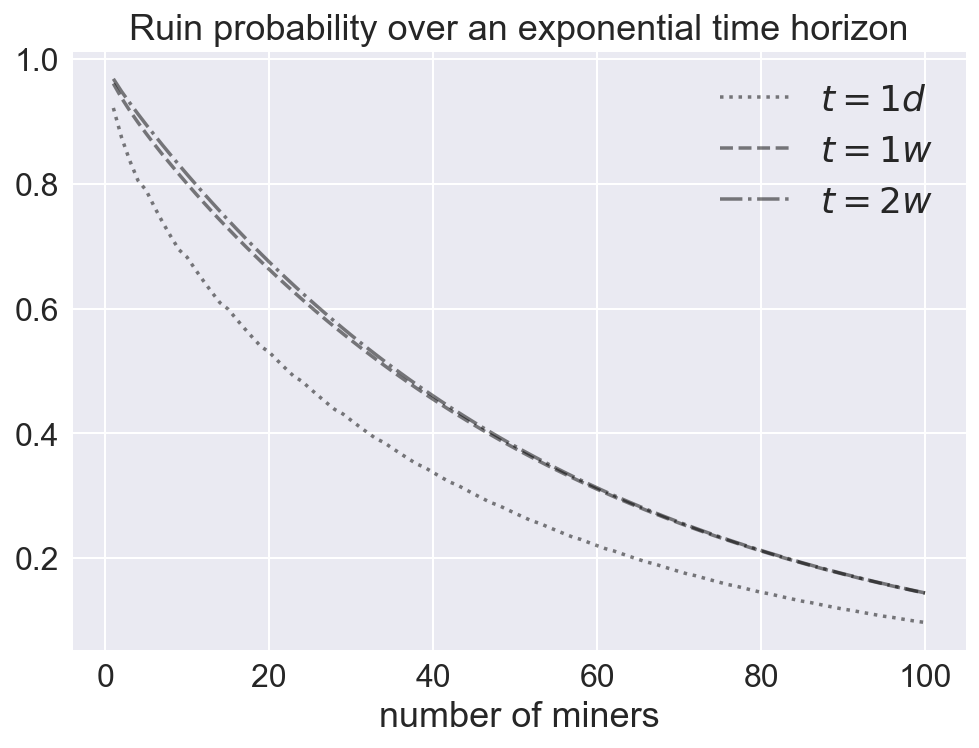

In [14]:
linestyles = ['dotted', 'dashed', 'dashdot']

t_names = np.array(['1d', '1w', '2w'])

for k in range(len(t_vec)):
    plt.plot(n_miner_vec, (ψ_V_pool.ψ_u_T[np.around(ψ_V_pool.t.values, decimals = 0) == t_vec[k]].values),
             color = 'k', alpha = 0.5,linestyle = linestyles[k], label = '$t = '+t_names[k]+'$')


plt.xlabel('number of miners', fontsize = fontsize_axes)
plt.title('Ruin probability over an exponential time horizon', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = fontsize_axes)

plt.savefig("../Figures/pro_rp_pool.pdf", bbox_inches='tight')

## Section 4.2

Now we turn to the computation of ruin probability and expected profit of a selfish miner

In [14]:
# Share of the computing power of Antpool
λ, t, p, q =6, 6, 0.1 , 0.5
denom = 1+2*p-p**2
p_U = [(1+p*(1-p)+p*(1-p)**2*(1-q))/denom, (p*q*(1-p)**2)/denom, (p**2+p**2*(1-p))/denom]
  
print('The net benefit condition holds if the price is smaller than '
      + str(np.around(λ * b / W, decimals = 3))+
      ' when following the protocol')
print('The net benefit condition holds if the price is smaller than '
      + str(np.around(b*λ*(p_U[1]+2*p_U[2]) / W / p , decimals = 3))+
      ' when mining selfishly')

The net benefit condition holds if the price is smaller than 0.065 when following the protocol
The net benefit condition holds if the price is smaller than 0.043 when mining selfishly


Figure 6 provides the net benefit frontier depending on the hashpower and connectivity

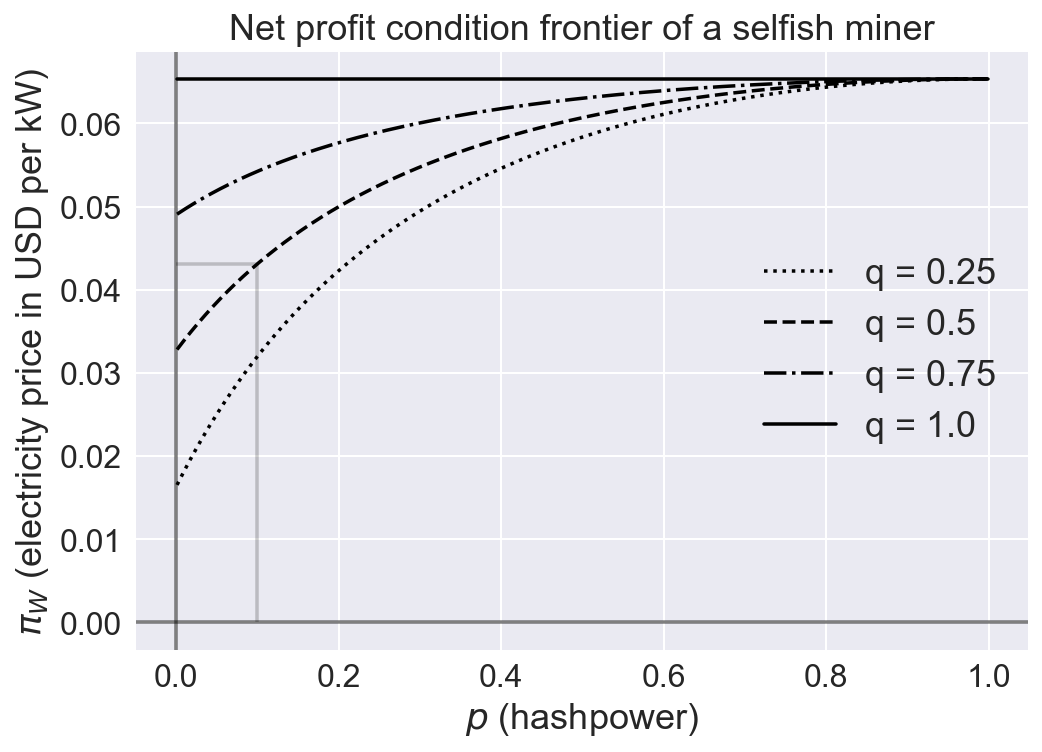

In [15]:
λ, p =6, 0.1
def f_πW(p,q): return((1/ p / W) * b * λ * (q * p * (1-p)**2 + 4 * p**2 - 2 * p**3)/(1 + 2 * p - p**2))

linestyles = ['dotted', 'dashed', 'dashdot', 'solid']
q_vec_ex = np.array([0.25, 0.5, 0.75, 1])

for k in range(len(q_vec_ex)) :  
    plt.plot(np.arange(0.001,1,0.001), np.array([f_πW(p,q_vec_ex[k]) for p in np.arange(0.001,1,0.001)]),
             color = 'k', alpha = 1, linestyle =linestyles[k], label = 'q = '+str(q_vec_ex[k]))
    
plt.vlines(x=0.1, ymin=0, ymax=f_πW(0.1,0.5), color = 'k', linestyle = '-',alpha = 0.2)
plt.hlines(y=f_πW(0.1,0.5), xmin=0, xmax=0.1, color = 'k', linestyle = '-', alpha = 0.2)
plt.tick_params(labelsize=fontsize_ticker)
plt.axvline(0, color = 'k', alpha = 0.5)
plt.axhline(0, color = 'k', alpha =0.5)
plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.ylabel('$π_W$ (electricity price in USD per kW)', fontsize = fontsize_axes)
plt.title('Net profit condition frontier of a selfish miner', fontsize = fontsize_axes)

plt.legend(fontsize = fontsize_axes)

plt.savefig("../Figures/nbc_selfish_q.pdf", bbox_inches='tight')


Code to generate the data to check that our results are consistent with MC simulations 

In [16]:
π_W = 0.04
u_vec = np.arange(10000, 405000, 10000) # Sequence of initial reserves
# K = 250000 #Number of sample path
Z_0 = 0
c = p * π_W * W 
sim_data = sim_data_self_T(t, λ, p, q, Z_0, K, rg)
res_T = np.array([V_T_self_MC(u, t, λ, p, q, b, c, sim_data) for u in u_vec])
ψ_V_MC_df = pd.DataFrame({'u':u_vec,
                    'ψ_u_T':res_T[:,0],
                    'ψ_u_T_low':res_T[:,0] - res_T[:,1],
                    'ψ_u_T_up':res_T[:,0] + res_T[:,1],
                    'V_u_T':res_T[:,2],
                    'V_u_T_low':res_T[:,2] - res_T[:,3] ,
                    'V_u_T_up':res_T[:,2] + res_T[:,3] }
                    )

Figure 7a)

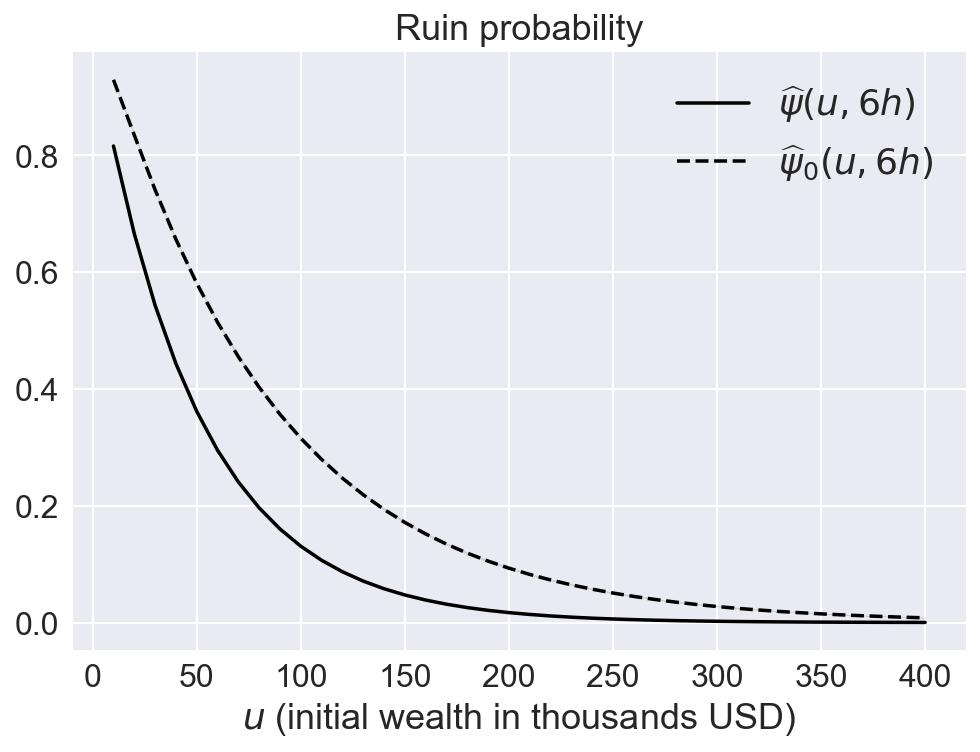

In [17]:
λ, t, p, q =6, 6, 0.1 , 0.5
ψ_selfish_MC_df = pd.read_csv("../Maple/rp_selfish_MC.csv", header = 0) 
π_W = 0.04
u_vec = np.arange(10000, 405000, 10000) # Sequence of initial reserves
Z_0 = 0
c = p * π_W * W 
ψ_u_T_vec = [ψ_T(u, t, b, c, p, λ) for u in u_vec]
plt.plot(u_vec/1000, ψ_u_T_vec, '-', linestyle = 'solid',color = 'k', alpha = 1, label = '$\widehat{\psi}(u, 6h)$')
plt.plot(u_vec/1000, ψ_selfish_MC_df.psi_T.values, '-', linestyle = 'dashed',color = 'k', label =  '$\widehat{\psi}_0(u, 6h)$')

plt.fill_between(u_vec/1000,  ψ_V_MC_df['ψ_u_T_low'].values, ψ_V_MC_df['ψ_u_T_up'].values, alpha=0.2, color = 'grey')
plt.xlabel('$u$ (initial wealth in thousands USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.legend(fontsize = fontsize_axes)
plt.savefig("../Figures/self_rp_u_MC.pdf", bbox_inches='tight') 

Figure 7b)

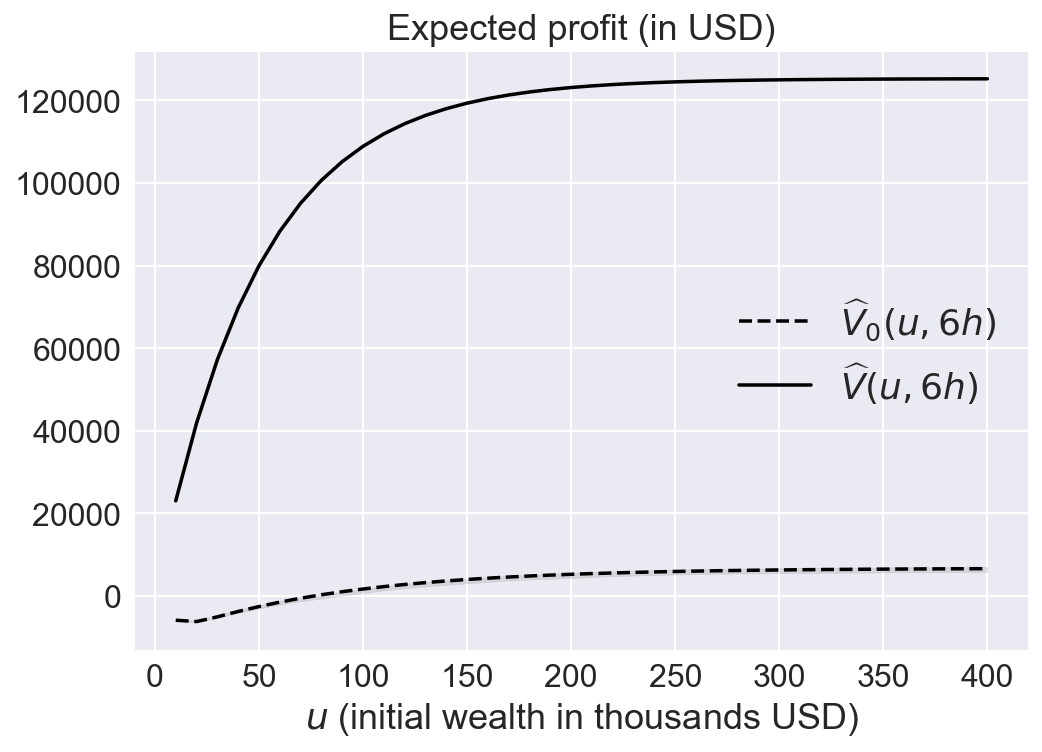

In [18]:
V_selfish_MC_df = pd.read_csv("../Maple/V_selfish_MC.csv", header = 0) 
V_u_T_vec = [V_T(u, t, b, c, p, λ)-u for u in u_vec]
plt.plot(u_vec/1000, V_selfish_MC_df.V_T.values - u_vec, '-', linestyle = 'dashed',color = 'k', label =  '$\widehat{V}_0(u, 6h)$')
plt.plot(u_vec/1000, V_u_T_vec, '-', linestyle = 'solid',color = 'k', alpha = 1, label = '$\widehat{V}(u, 6h)$')
plt.fill_between(u_vec/1000,  ψ_V_MC_df['V_u_T_low'].values-u_vec, ψ_V_MC_df['V_u_T_up'].values-u_vec, alpha=0.2, color = 'grey')
plt.xlabel('$u$ (initial wealth in thousands USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.title('Expected profit (in USD)', fontsize = fontsize_axes)
plt.legend(fontsize = fontsize_axes)
plt.savefig("../Figures/self_rev_u_MC.pdf", bbox_inches='tight')

Code to get the data for the sensivity analysis of the expected profit depending on the connectivity as a function of the initial reserve

In [19]:
t = 14*24
V_selfish_df = pd.read_csv("../Maple/V_selfish_data_q1.csv", header = 0).rename(columns={'&pi;_W': 'π_W' })
V_selfish_df.columns
V_selfish_df['EG'] = V_selfish_df.u + t*np.array([
    η(V_selfish_df.p[k], V_selfish_df.q[k], b, λ, V_selfish_df.π_W[k], W)
     for k in range(len(V_selfish_df.u))])
u_vec = np.arange(1000, 1001000, 1000)
t_vec = np.array([14*24])
π_W_vec = np.arange(0.03, 0.051, 0.01)
p_vec = np.arange(0.1, 0.14, 0.02)
V_protocol_df = pd.DataFrame({'u':[],'t':[],'π_W':[], 'p':[],'V_u_T':[], 'EG':[]})
for t in t_vec:
    for π_W in π_W_vec:
        for p in p_vec:
            c = p * π_W * W
            res = pd.DataFrame({'u':u_vec,
                        't':np.repeat(t, len(u_vec)), 
                        'π_W':np.repeat(π_W, len(u_vec)),
                        'p':np.repeat(p, len(u_vec)),
                        'V_u_T':[ V_T(u, t, b, c, p, λ) for u in u_vec],
                       'EG': [u - c * t + p * λ * b * t for u in u_vec] 
                               })
            V_protocol_df = pd.concat([V_protocol_df, res])

Figure 8 a)

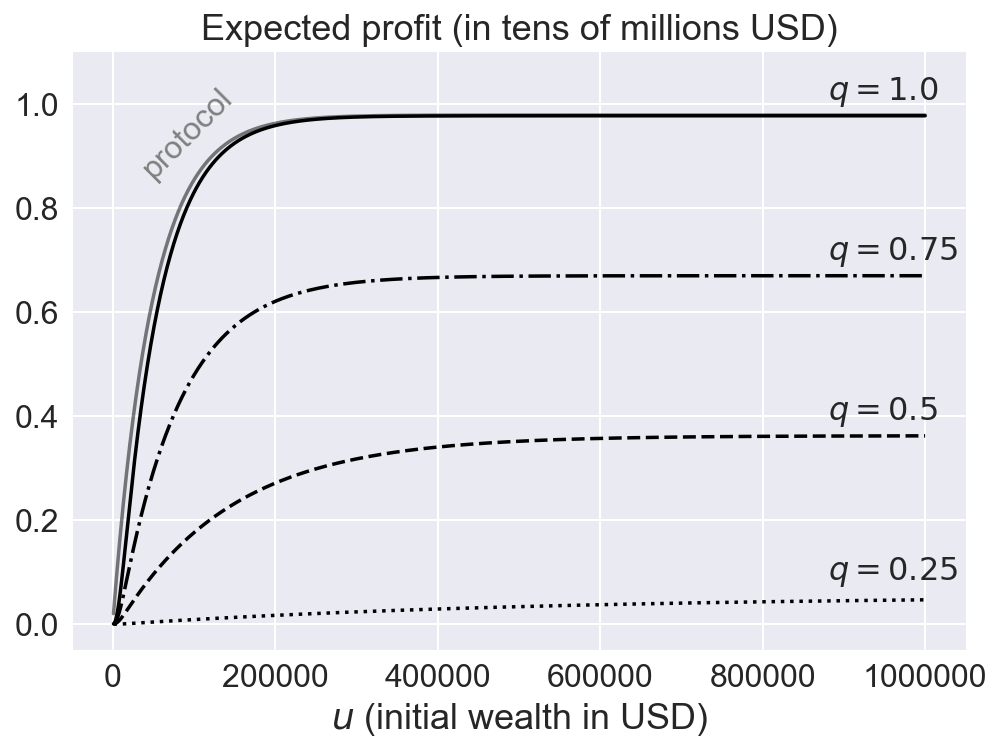

In [20]:
linestyles = ['dotted', 'dashed', 'dashdot', 'solid']
#Selection of the data
π_W = 0.03
p = 0.1
select_self = (np.around(V_selfish_df.π_W.values, decimals = 3) == π_W) & (np.around(V_selfish_df.p.values, decimals = 2) == p)
q_vec_ex = np.array([0.25, 0.5, 0.75, 1])
for k in range(len(q_vec_ex)):

    plt.plot(u_vec, V_selfish_df.V_T[(select_self) & (np.around(V_selfish_df.q.values, decimals = 2) == q_vec_ex[k])].values -u_vec ,
             color = 'k', alpha = 1, linestyle =linestyles[k] )

    plt.text(u_vec[-120], V_selfish_df.EG[(select_self) &  (np.around(V_selfish_df.q.values, decimals = 2) == q_vec_ex[k])].values[-1]
             -u_vec[-1]+300000,'$q = '+ str(q_vec_ex[k])+'$', fontsize = fontsize_ticker)
plt.xlabel('$u$ (initial wealth in USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in tens of millions USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
select_pro = (np.around(V_protocol_df.π_W.values, decimals = 3) == π_W) &\
(np.around(V_protocol_df.p.values, decimals = 2) == p)
plt.plot(u_vec, V_protocol_df.V_u_T[select_pro].values -u_vec, color = 'k', alpha = 0.5, linestyle = 'solid')

# Locations to plot text
l2 = np.array((u_vec[50], V_protocol_df.V_u_T[select_pro].values[100] -u_vec[100]))

# Rotate angle
angle = 45
trans_angle = plt.gca().transData.transform_angles(np.array((45,)),
                                                   l2.reshape((1, 2)))[0]

plt.text(l2[0], l2[1],'protocol', fontsize = fontsize_ticker, color = 'grey',  rotation=angle, rotation_mode='anchor')
plt.ylim(top=11000000)
plt.setp(plt.gca().get_yaxis().get_offset_text(), visible=False)
plt.savefig("../Figures/self_rev_u.pdf", bbox_inches='tight')


Figure 8b)

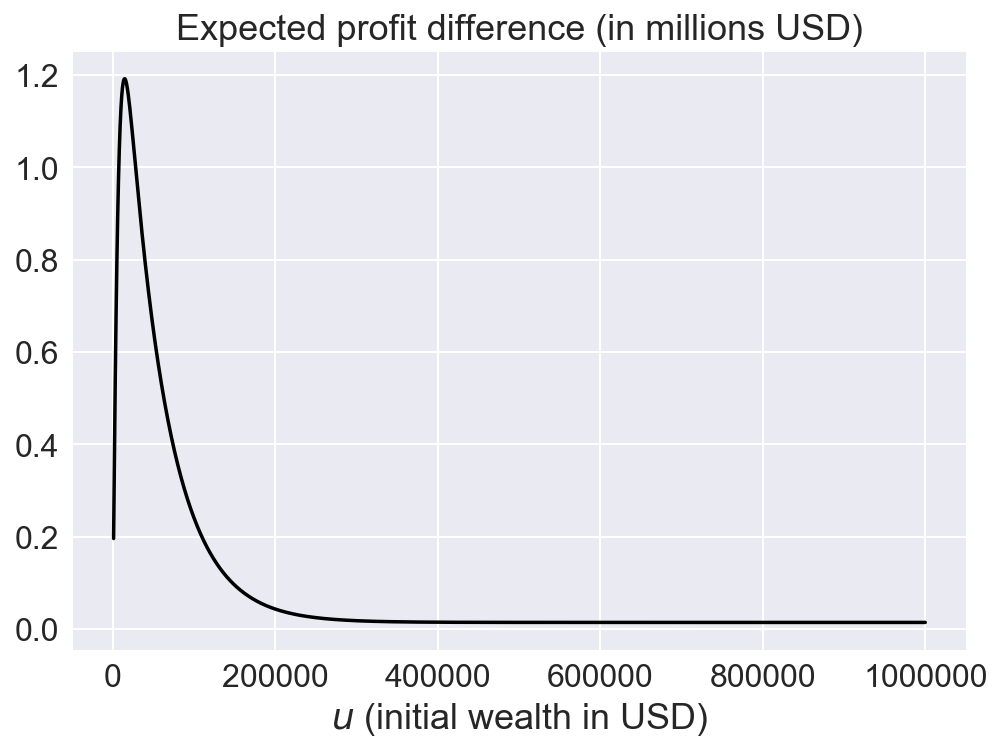

In [21]:
#Selection of the data
π_W = 0.03
p = 0.1
q = 1
select_self = (np.around(V_selfish_df.π_W.values, decimals = 3) == π_W) & (np.around(V_selfish_df.p.values, decimals = 2) == p)\
&(np.around(V_selfish_df.q.values, decimals = 2) == q)
select_pro = (np.around(V_protocol_df.π_W.values, decimals = 3) == π_W) &\
(np.around(V_protocol_df.p.values, decimals = 2) == p)

plt.plot(u_vec, (V_protocol_df.V_u_T[select_pro].values - V_selfish_df.V_T[(select_self)].values)/1000000 ,
         color = 'k', alpha = 1, linestyle =linestyles[k])

plt.xlabel('$u$ (initial wealth in USD)', fontsize = fontsize_axes)

plt.title('Expected profit difference (in millions USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.setp(plt.gca().get_yaxis().get_offset_text(), visible=False)
plt.savefig("../Figures/diff_rev_pro_rev_u.pdf", bbox_inches='tight')


Code to generate the data for the sensitivity analysis of the expected profit of a selfish miner

In [22]:
t = 14*24

V_selfish_df = pd.read_csv("../Maple/V_selfish_data.csv", header = 0).rename(columns={'&pi;_W': 'π_W' })
V_selfish_df.columns
V_selfish_df['EG'] = V_selfish_df.u + t*np.array([
    η(V_selfish_df.p[k], V_selfish_df.q[k], b, λ, V_selfish_df.π_W[k], W)
     for k in range(len(V_selfish_df.u))])
u_vec = np.arange(10000, 1050000, 50000)
t_vec = np.array([14*24])
π_W_vec = np.arange(0.02, 0.081, 0.01)
p_vec = np.arange(0.04, 0.22, 0.02)
V_protocol_df = pd.DataFrame({'u':[],'t':[],'π_W':[], 'p':[],'V_u_T':[], 'EG':[]})
for t in t_vec:
    for π_W in π_W_vec:
        for p in p_vec:
            c = p * π_W * W
            res = pd.DataFrame({'u':u_vec,
                        't':np.repeat(t, len(u_vec)), 
                        'π_W':np.repeat(π_W, len(u_vec)),
                        'p':np.repeat(p, len(u_vec)),
                        'V_u_T':[ V_T(u, t, b, c, p, λ) for u in u_vec],
                       'EG': [u - c * t + p * λ * b * t for u in u_vec] 
                               })
            V_protocol_df = pd.concat([V_protocol_df, res])

Figure 9a

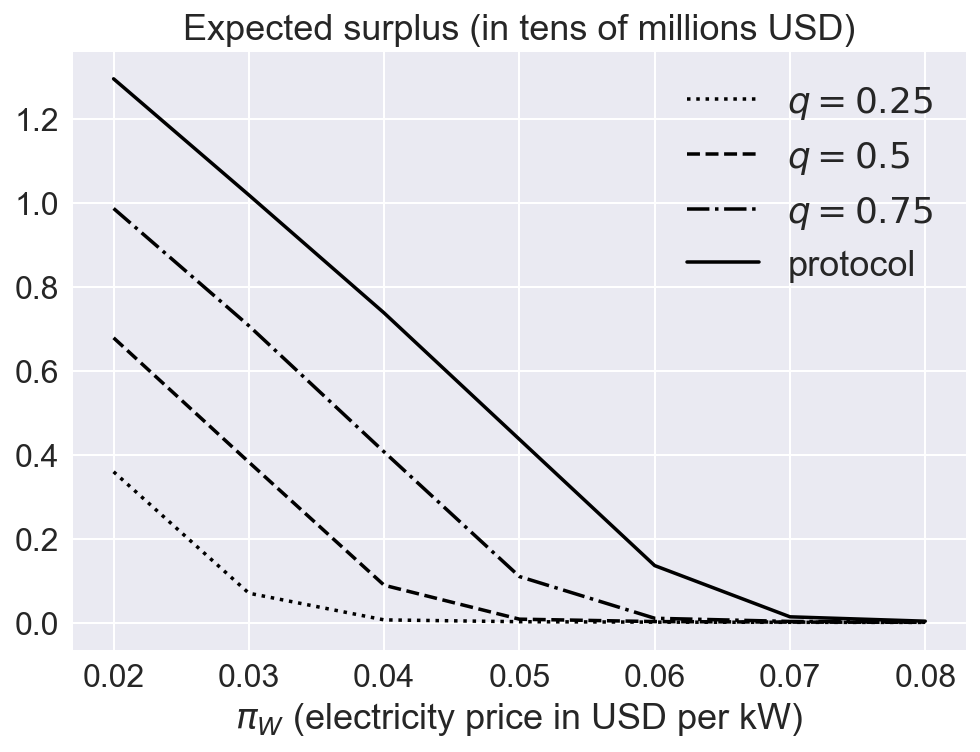

In [23]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
p = 0.1
u = 410000
select_self = (np.around(V_selfish_df.p.values, decimals = 2) == p) & (np.around(V_selfish_df.u.values, decimals = 0) == u)
q_vec_ex = np.array([0.25, 0.5, 0.75])
for k in range(len(q_vec_ex)):
    plt.plot(π_W_vec, V_selfish_df.V_T[(select_self) & (np.around(V_selfish_df.q.values, decimals = 2) == q_vec_ex[k])].values,
             color = 'k', alpha = 1, linestyle =linestyles[k], label = '$q = '+str(q_vec_ex[k])+'$')
plt.xlabel('$\pi_W$ (electricity price in USD per kW)', fontsize = fontsize_axes)
plt.title('Expected surplus (in tens of millions USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)

select_pro = (np.around(V_protocol_df.u.values, decimals = 0) == u) & (np.around(V_protocol_df.p.values, decimals = 2) == p)
plt.plot(π_W_vec, V_protocol_df.V_u_T[select_pro].values, color = 'k', alpha = 1, linestyle = 'solid', label = 'protocol')
plt.setp(plt.gca().get_yaxis().get_offset_text(), visible=False)
plt.legend(fontsize = fontsize_axes)
plt.savefig("../Figures/self_rev_pkW.pdf", bbox_inches='tight')

Figure 9b

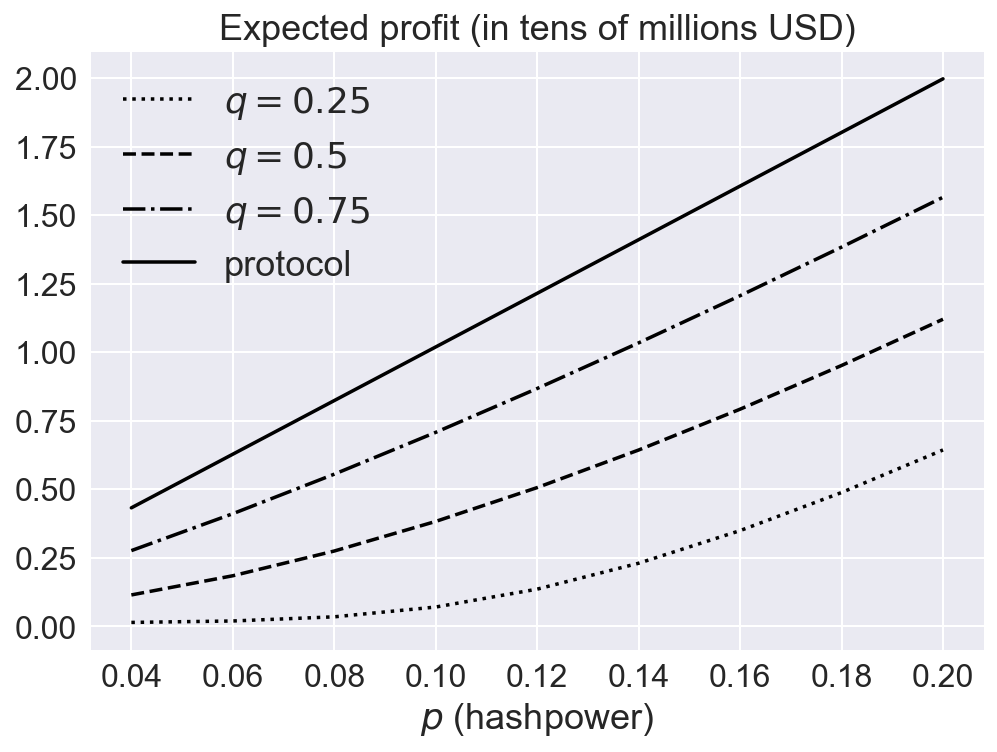

In [24]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
π_W = 0.03
u = 410000
select_self = (np.around(V_selfish_df.π_W.values, decimals = 3) == π_W) & (np.around(V_selfish_df.u.values, decimals = 0) == u)
q_vec_ex = np.array([0.25, 0.5, 0.75])
for k in range(len(q_vec_ex)):
    plt.plot(p_vec, V_selfish_df.V_T[(select_self) & (np.around(V_selfish_df.q.values, decimals = 2) == q_vec_ex[k])].values,
             color = 'k', alpha = 1, linestyle =linestyles[k], label = '$q = '+str(q_vec_ex[k])+'$')
plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.title('Expected profit (in tens of millions USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)

select_pro = (np.around(V_protocol_df.u.values, decimals = 0) == u) & (np.around(V_protocol_df.π_W.values, decimals = 3) == π_W)
plt.setp(plt.gca().get_yaxis().get_offset_text(), visible=False)
plt.plot(p_vec, V_protocol_df.V_u_T[select_pro].values, color = 'k', alpha = 1, linestyle = 'solid', label = 'protocol')
# plt.hlines(u, π_W_vec[0],π_W_vec[-1],alpha = 0.2, linestyle = 'solid') 
plt.legend(fontsize = fontsize_axes)

plt.savefig("../Figures/self_rev_p.pdf", bbox_inches='tight')

## Section 5

In [25]:
#Retrieved on 01/01/2020
# Hashrate of the network
H = 97.01 * 10**18 * 600
# Estimated target on the first segment. 
L = 2**256 / H
print("The current target is "+str(L)+" compared to " + str(L * H))

The current target is 1.989349710293032e+54 compared to 1.157920892373162e+77


Data for the miner who follow the protocol over two segements

In [26]:
u_vec = np.arange(5000, 1105000, 5000)
t_vec = np.array([28*24])
π_W_vec = np.arange(0.04, 0.91, 0.01)
p_vec = np.arange(0.05, 0.21, 0.05)
V_protocol_df = pd.DataFrame({'u':[],'t':[],'π_W':[], 'p':[],'V_T':[], 'EG':[]})
for t in t_vec:
    for π_W in π_W_vec:
        for p in p_vec:
            c = p * π_W * W
            res = pd.DataFrame({'u':u_vec,
                        't':np.repeat(t, len(u_vec)), 
                        'π_W':np.repeat(π_W, len(u_vec)),
                        'p':np.repeat(p, len(u_vec)),
                        'V_T':[ V_T(u, t, b, c, p, λ) for u in u_vec],
                       'EG': [p*λ*b - c for u in u_vec] 
                               })
            V_protocol_df = pd.concat([V_protocol_df, res])
V_protocol_df

,u,t,π_W,p,V_T,EG
0,5000.0,672.0,0.04,0.05,4.208966e+05,1.044006e+04
1,10000.0,672.0,0.04,0.05,8.171386e+05,1.044006e+04
2,15000.0,672.0,0.04,0.05,1.190188e+06,1.044006e+04
3,20000.0,672.0,0.04,0.05,1.541418e+06,1.044006e+04
4,25000.0,672.0,0.04,0.05,1.872124e+06,1.044006e+04
...,...,...,...,...,...,...
215,1080000.0,672.0,0.90,0.20,6.354030e+02,-1.374249e+06
216,1085000.0,672.0,0.90,0.20,6.412796e+02,-1.374249e+06
217,1090000.0,672.0,0.90,0.20,6.471832e+02,-1.374249e+06
218,1095000.0,672.0,0.90,0.20,6.531138e+02,-1.374249e+06


Net profit frontier for a miner being selfish during the first segment, Figure 10a

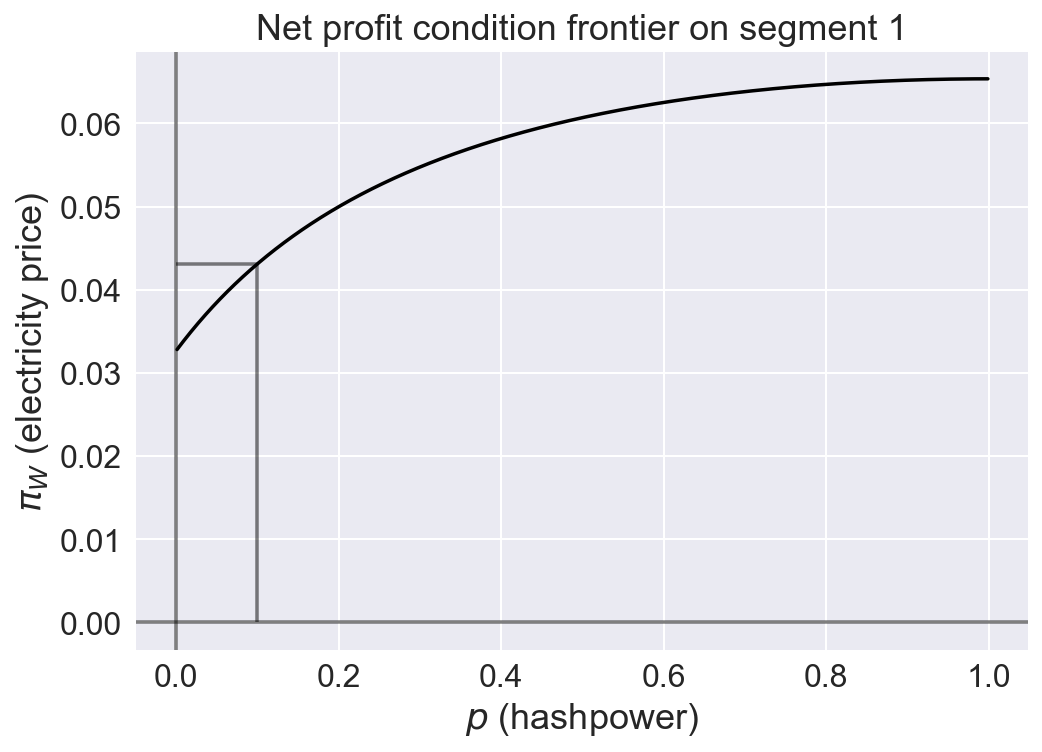

In [27]:
q = 0.5
def f_π_W(p): return((1/ p / W) * b * λ * (q * p * (1-p)**2 + 4 * p**2 - 2 * p**3)/(1 + 2 * p - p**2))

plt.plot(np.arange(0.001,1,0.001), np.array([f_π_W(p) for p in np.arange(0.001,1,0.001)]),
         color = 'k', alpha = 1, linestyle ='solid' )
plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.ylabel('$π_W$ (electricity price)', fontsize = fontsize_axes)
plt.title('Net profit condition frontier on segment 1', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.vlines(x=0.1, ymin=0, ymax=f_π_W(0.1), color = 'k', linestyle = '-', alpha = 0.5)
plt.hlines(y=f_π_W(0.1), xmin=0, xmax=0.1, color = 'k', linestyle = '-', alpha = 0.5)
plt.axvline(0, color = 'k', alpha = 0.5)
plt.axhline(0, color = 'k', alpha =0.5)


plt.savefig("../Figures/nbc_segment1.pdf", bbox_inches='tight')

Collecting the data of the expected surplus (taking ruin into account) over the first segment

In [28]:
q = 0.5
# Arrival rate in the blockchain when a miner with hashpower p is mining selfishly
λ_1_vec = [λ * (1 - p * (1 - p) / (1 + 2 * p - p**2)) for p in p_vec]
# Duration of the first segement when a miner with hashpower p is mining selfishly
t_1_vec = [ 2016 / λ / (1 - p * (1 - p) / (1 + 2 * p - p**2)) for p in p_vec]
# The revenue over the first segement is evaluated through maple and reported as the variable u_2
V_self1_df = pd.read_csv("../Maple/V_seg1_data.csv", header = 0).rename(
    columns = {'&lambda;_1':'λ_1', 'V_T':'u_2','pkW':'π_W'}).drop('Unnamed: 0', axis = 1)
V_self1_df

,u,t_1,λ_1,π_W,p,u_2
0,5000,351.2,5.740319,0.04,0.05,998.5091
1,10000,351.2,5.740319,0.04,0.05,3624.5931
2,15000,351.2,5.740319,0.04,0.05,6813.6100
3,20000,351.2,5.740319,0.04,0.05,10142.2614
4,25000,351.2,5.740319,0.04,0.05,13508.3286
...,...,...,...,...,...,...
5275,1080000,380.8,5.294118,0.09,0.20,25144.3700
5276,1085000,380.8,5.294118,0.09,0.20,25365.6500
5277,1090000,380.8,5.294118,0.09,0.20,25587.8900
5278,1095000,380.8,5.294118,0.09,0.20,25811.0800


Net Profit condition frontier over Segment 2 Figure 10b

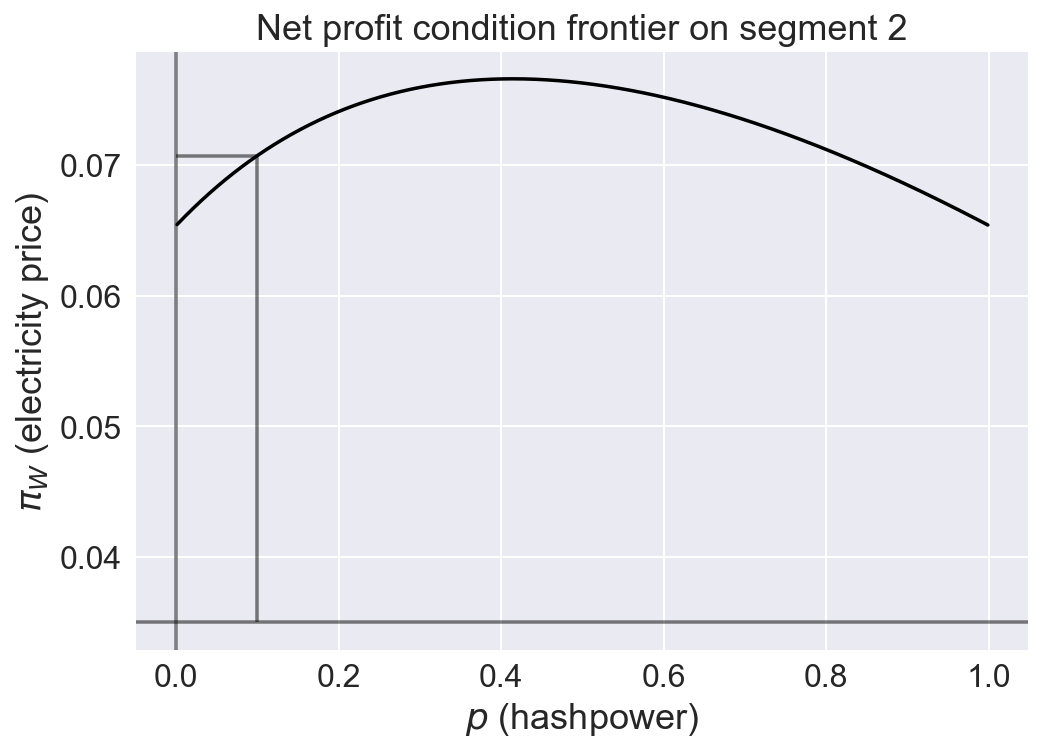

In [29]:
# Target resulting from selfish mining
L_2 = L * V_self1_df['t_1'] / 336
# Number of hashes
λ_2 = 1 / ( 2**256 / L_2 / H / 6)
#net benefit condition
def π_W(p): return(2016 / 336 * b * 6 / λ / (1 - p * (1 - p) / (1 + 2 * p - p**2)) / W )

plt.plot(np.arange(0.001,1,0.001), np.array([π_W(p) for p in np.arange(0.001,1,0.001)]),
         color = 'k', alpha = 1, linestyle ='solid')

plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.ylabel('$π_W$ (electricity price)', fontsize = fontsize_axes)
plt.title('Net profit condition frontier on segment 2', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.vlines(x=0.1, ymin=0.035, ymax=π_W(0.1), color = 'k', linestyle = '-', alpha =0.5)
plt.hlines(y=π_W(0.1), xmin=0, xmax=0.1, color = 'k', linestyle = '-', alpha =0.5)
plt.axvline(0, color = 'k', alpha = 0.5)
plt.axhline(0.035, color = 'k', alpha =0.5)


plt.savefig("../Figures/nbc_segment2.pdf", bbox_inches='tight')

In [30]:
#Computation of the arrival rates of block for the second segment
V_self1_df['λ_2'] = 1/( 2**256 / L_2 / H / 6)
V_self1_df['t_2'] = 2016 / V_self1_df['λ_2']
V_self1_df['V_T'] = [V_T_bis(V_self1_df.u[k], V_self1_df.t_2[k], b, V_self1_df.p[k], V_self1_df.λ_2[k], V_self1_df.π_W[k],
                             W) for k in range(len(V_self1_df['λ_2']))]

#Selection of the data
π_W = 0.06
p = 0.1

# operational cost per hour
c = p * π_W * W
select_self = (np.around(V_self1_df.π_W.values, decimals = 3) == π_W) & (np.around(V_self1_df.p.values, decimals = 2) == p)
select_pro = (np.around(V_protocol_df.π_W.values, decimals = 3) == π_W) & (np.around(V_protocol_df.p.values, decimals = 2) == p)

print("The  average gain per time unit amounts to $" + str((p*λ*b - c)) + " when following the protocol")
print("The expected gain amounts to $" + str((p*λ*b - c)*28*24) + " when following the protocol")
print("The average gain per time unit amounts to $" + str(η(p, q, b, λ, π_W, W)) + " when mining selfishly on first segment")
print("The average gain per time unit amounts to  $" + 
      str((p* V_self1_df.λ_2[(select_self)].values[0] * b - c)) + 
      " when mining selfishly on first segment")
print("The expected gain amounts to $" + 
      str((p* V_self1_df.λ_2[(select_self)].values[0] * b - c)*V_self1_df.t_2[(select_self)].values[0]) + 
      " when resuming to protocol on second segment")

The  average gain per time unit amounts to $4414.892204622993 when following the protocol
The expected gain amounts to $2966807.5615066513 when following the protocol
The average gain per time unit amounts to $-13898.792615798404 when mining selfishly on first segment
The average gain per time unit amounts to  $8817.57603159437 when mining selfishly on first segment
The expected gain amounts to $2738635.379156111 when resuming to protocol on second segment


Figure 11

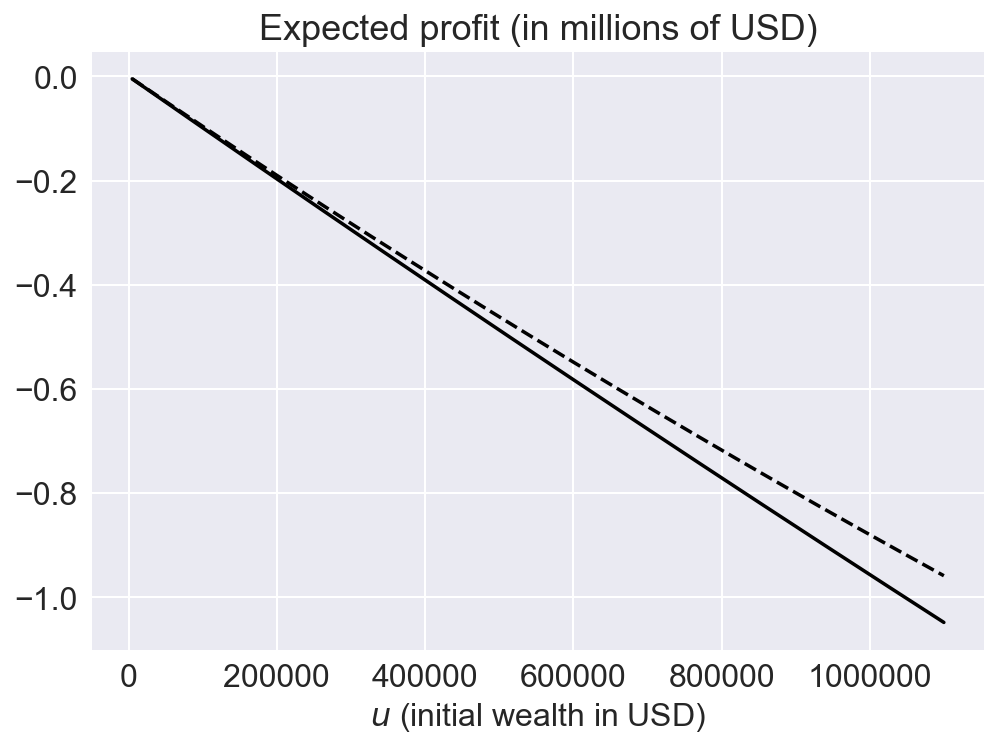

In [31]:
#Selection of the data
π_W_vec_ex = np.array([[0.04, 0.05,0.06]
                       , [0.07, 0.08, 0.09]])
p = 0.1

# fig, axs = plt.subplots(len(π_W_vec_ex[: ,0]),len(π_W_vec_ex[0 ,:]),  constrained_layout=True)
for k in range(len(π_W_vec_ex[: ,0])):
    for l in range(len(π_W_vec_ex[0 ,:])):
        select_self = (np.around(V_self1_df.π_W.values, decimals = 3) == π_W_vec_ex[k,l])\
        & (np.around(V_self1_df.p.values, decimals = 2) == p)
        select_pro = (np.around(V_protocol_df.π_W.values, decimals = 3) == π_W_vec_ex[k,l])\
        & (np.around(V_protocol_df.p.values, decimals = 2) == p)
        plt.clf()
        plt.plot(u_vec, (V_self1_df.V_T[(select_self)].values-u_vec)/1000000,
                 color = 'k', alpha = 1, linestyle ='dashed' )
        plt.plot(u_vec, (V_protocol_df.V_T[(select_pro)].values-u_vec)/1000000,
                 color = 'k', alpha = 1, linestyle ='solid' )
        plt.xlabel('$u$ (initial wealth in USD)', fontsize = fontsize_ticker)
        plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
        plt.tick_params(labelsize=fontsize_ticker)
#         plt.xaxis.set_label_coords(1.05, 0.1)
        plt.savefig("../Figures/rev_difficulty_adjusment_"+str(np.int(π_W_vec_ex[k,l]*100))+".pdf", bbox_inches='tight')
# fig.suptitle('Revenue net of initial wealth (in millions of USD)', fontsize = fontsize_axes)
